# Loading classes and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from function import Function
from utils import split_data, tastes
from methods import clusters_goodness,cuckoo_kmeans, hit_ratio, recommendation
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")



# Loading Data

In [2]:
R = pd.read_csv('ratings.csv')
R = R.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
R = R.values
R[R > 0] = 1

splitting data into training and test sets

In [3]:
R, test_val_sets = split_data(R,0.3)

In [4]:
# loading the matrix factorization latent matrix
U_mf=pd.read_csv('user_latent_matrix_mf.csv',header=None)
U_mf=U_mf.values

# loading the neural net latent space
U_ncf=pd.read_csv('user_latent_matrix_ncf.csv',header=None)
U_ncf=U_ncf.values
U_ncf, *_ = split_data(U_ncf,0.3)

# Setting the limits of U space

In [5]:
bounds=[]
print_status=0
words=['mf','ncf']
for D in [U_mf,U_ncf]:
    # find the 90th and 10th quantile of each column
    max_values = np.percentile(D, q=90, axis=0)
    min_values = np.percentile(D, q=10, axis=0)

    # store bounds in a list
    bound = list(zip(min_values, max_values))

    # print the results
    print("90th quantile of each column for " + words[print_status]+':', max_values)
    print("10th quantile of each column for " + words[print_status]+':', min_values)
    bounds.append(bound)
    print_status+=1



90th quantile of each column for mf: [2.12899587 0.11418561 2.03015392 1.54165135]
10th quantile of each column for mf: [0. 0. 0. 0.]
90th quantile of each column for ncf: [0.0816108  0.07882707 0.07792799 0.0788335 ]
10th quantile of each column for ncf: [-0.08033266 -0.0769896  -0.07878304 -0.08327308]


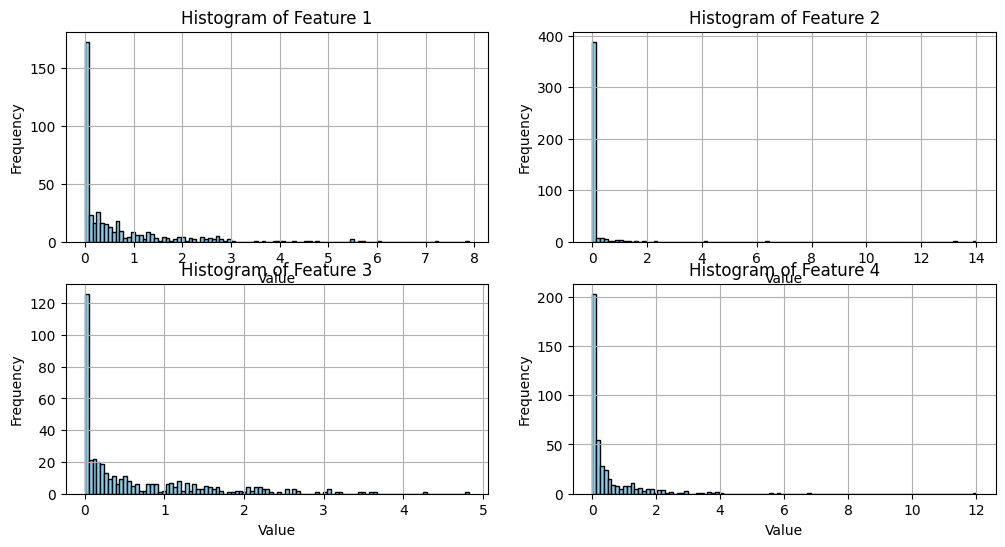

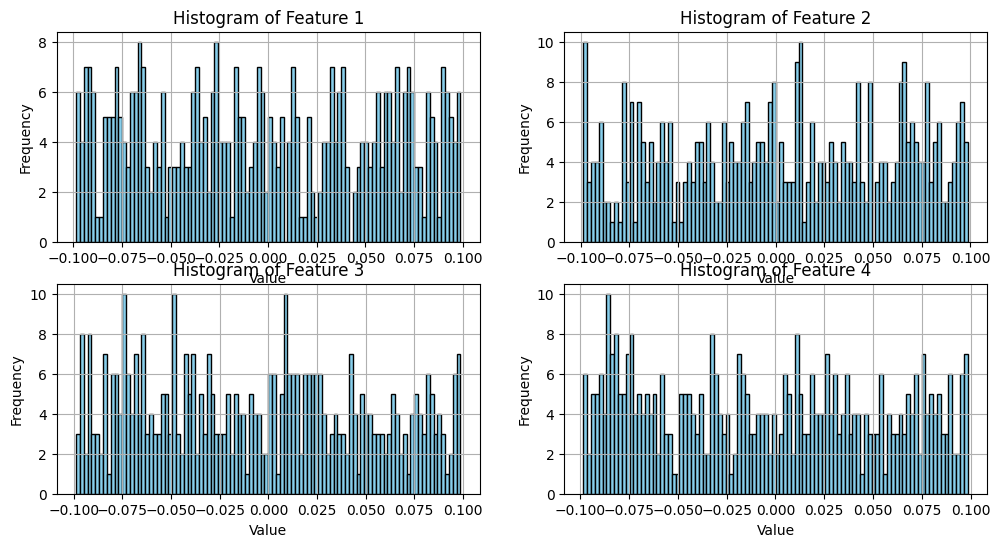

In [6]:
for D in [U_mf,U_ncf]:
    num_cols = D.shape[1]  
    num_rows = (num_cols + 1) // 2  

    # creating subplots in a grid layout
    fig, axs = plt.subplots(num_rows, 2, figsize=(12, num_rows * 3))  

    # flattening axs if there's only one row
    if num_rows == 1:
        axs = axs.reshape(1, -1)

    for i in range(num_cols):
        row = i // 2  
        col = i % 2   
        axs[row, col].hist(D[:, i], bins=100, color='skyblue', edgecolor='black')  # Plot histogram
        axs[row, col].set_xlabel('Value')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_title(f'Histogram of Feature {i+1}')
        axs[row, col].grid(True)

    # if there's an odd number of columns, remove the last subplot
    if num_cols % 2 != 0:
        fig.delaxes(axs[-1, -1])

# Objective functions

In [7]:
def objectivefunction(c=None,data=None,space_matrix=None):
    """Objective function
        Args
        ----
        c (np.array) : z x k matrix (z = # of centroids)
        data (np.array) : nonnegative n x m matrix
        space_matrix (np.array) : nonnegative n x k matrix
        p_matrix (np.array) : nonnegative k x m matrix
        Returns
        -------
        cos_sim_clusters_to_min (float) : 1 - cosine similarity produced by the clusterization
        """
    np.seterr(divide='ignore', invalid='ignore')
    
    # normalization mean = np.mean(original_array, axis=0)
    mean = np.mean(space_matrix, axis=0)
    variance = np.var(space_matrix, axis=0)
    norm_space_matrix = (space_matrix - mean) / np.sqrt(variance)

    # compute th distance between each data point and each centroid using the k-th norm
    distances = np.linalg.norm(norm_space_matrix[:, np.newaxis, :] - c, ord=2, axis=2)**2
    
    # assign each point to the cluster represented by the nearest centroid
    cluster_assignments = np.argmin(distances, axis=1)

    # project clusters and move clusterization froma space matrix to data
    clusters_data = []
    for cluster_index in range(c.shape[0]):
        cluster = data[cluster_assignments == cluster_index]
        clusters_data.append(cluster)

    # compute centroids in the original spce
    cluster_data_mean = np.array([np.mean(array, axis=0) for array in clusters_data])
   

    # initialize variable to store cumulative cosine similarity
    cos_sim_clusters = 0

    # calculate cosine similarity between cluster data and mean projected point
    for i in range(data.shape[0]):
        dot_product = np.dot(data[i],cluster_data_mean[cluster_assignments[i]].T)
        norm_data = np.linalg.norm(data[i,:])
        norm_mean = np.linalg.norm(cluster_data_mean[cluster_assignments[i]])
        cos_sim_clusters +=  dot_product / (norm_data * norm_mean)


    # average cosine similarity over all data points
    cos_sim_clusters /= data.shape[0]

    # compute the quantity to minimize
    cos_sim_clusters_to_min = 1-cos_sim_clusters 

    return cos_sim_clusters_to_min   

## Run

### choosing the number of latent features

We have chosen `k=4` as suggested by the result of the cross validation executed in the python notebook **run_mf** in the subfolder **matrix_factorization**

In [8]:
k=4

### choosing the number of clusters

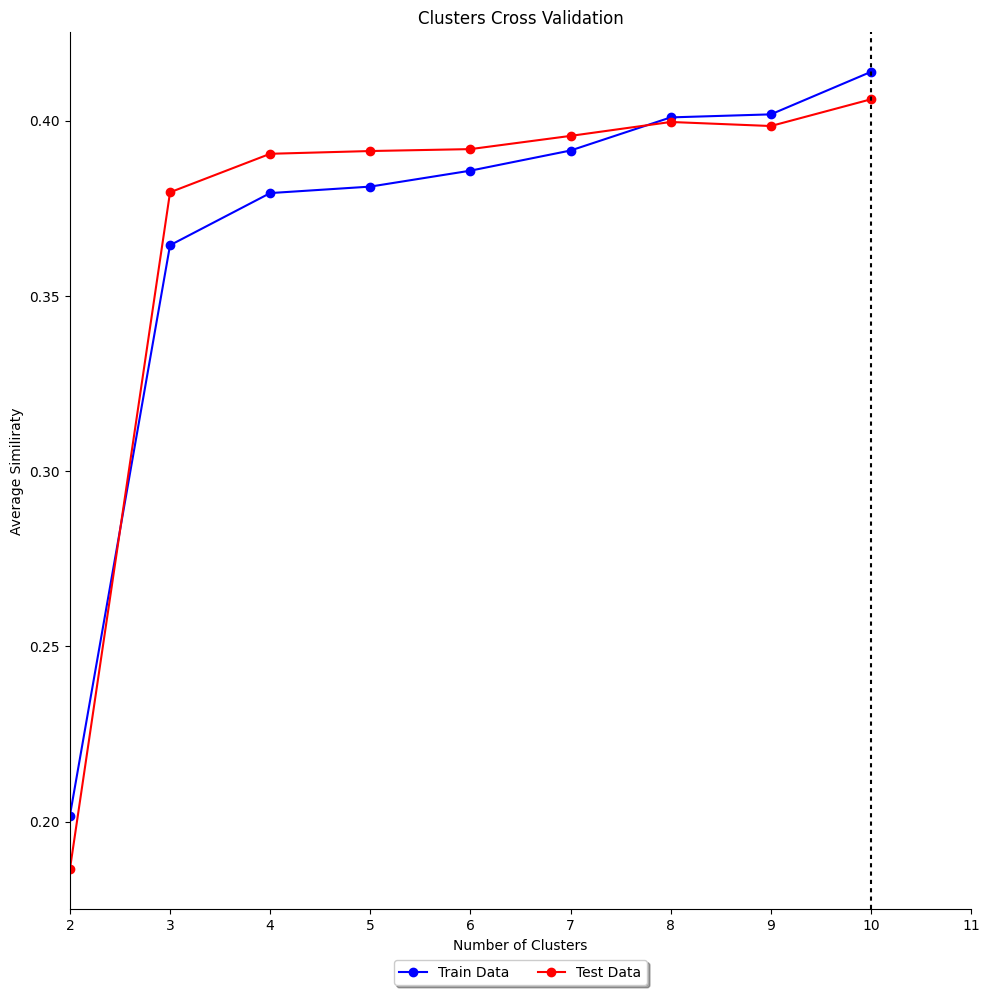

In [9]:
test_set, val_set = split_data(test_val_sets,0.5)
np.random.seed(55)
z=clusters_goodness(R,11,objectivefunction,k,val_set,U_mf,min_values=[item[0] for item in bounds[0]],max_values=[item[1] for item in bounds[0]])

Now we see how well we recommend new users

First we wrap the objective functions conditioning it to the space matrices produced by MF and NCF and their bounds.  
Then we load the obtained `k` and `z` as inputs

In [10]:
# setting the function for matrix factorization
obj_funct_mf=Function()
obj_funct_mf.set_expression(lambda x: objectivefunction(c=x, data=R, space_matrix=U_mf)) 

# setting the function for neural collaborative filtering factorization
obj_funct_ncf=Function()
obj_funct_ncf.set_expression(lambda x: objectivefunction(c=x, data=R, space_matrix=U_ncf)) 

# setting z as number of centorids in the objective functions
obj_funct_mf.set_function_params(BoundLower=[item[0] for item in bounds[0]],BoundUpper=[item[1] for item in bounds[0]],shape=[z,k])
obj_funct_ncf.set_function_params(BoundLower=[item[0] for item in bounds[1]],BoundUpper=[item[1] for item in bounds[1]],shape=[z,k])


We run our **CS-Kmeans algorithm** for both the MF and NCF cases

In [11]:
np.random.seed(32)
#ruuning cuckoo
final_centroids_mf = cuckoo_kmeans(original_space=R,cuckoosNumber=5,hostNumber=5,function=obj_funct_mf,iterNumber_cuckoo=500,lmbd=1.5,alpha=0.01,space=U_mf,max_iter_kmeans=10000,k=z,adpt=True,alpha_max=0.5,alpha_min=1e7,adp_rate=0.0001)
final_centroids_ncf = cuckoo_kmeans(original_space=R,cuckoosNumber=5,hostNumber=5,function=obj_funct_ncf,iterNumber_cuckoo=500,lmbd=1.5,alpha=0.01,space=U_ncf,max_iter_kmeans=10000,k=z,adpt=True,alpha_max=0.5,alpha_min=1e7,adp_rate=0.0001)


<class 'numpy.float64'>
Best = 0.372881290151
Coordinates of the best:
[5.43014, 0.8248, 0.49566, 0.41189] 

[2.06063, 11.21483, 1.34062, 0.70386] 

[1.95079, 0.51672, 1.87006, 2.28722] 

[2.51989, 0.03597, 0.4325, 0.45021] 

[1.24096, 0.02809, 0.3282, 0.22882] 

[0.29323, 0.19153, 0.87291, 2.87084] 

[0.02477, 0.01025, 2.04691, 0.07338] 

[0.38758, 0.95541, 0.28602, 7.56094] 

[0.23458, 0.02391, 0.16695, 0.1706] 

[0.20999, 0.06196, 0.44367, 1.22807] 

<class 'numpy.float64'>
Best = 0.325810535180
Coordinates of the best:
[0.03634, -0.01256, -0.06379, -0.06746] 

[-0.05163, -0.05276, 0.01798, 0.05009] 

[0.06356, 0.0558, -0.03177, 0.03858] 

[-0.04087, -0.05058, 0.03394, -0.05482] 

[0.04228, 0.05892, 0.02416, -0.06356] 

[-0.05741, 0.04854, 0.01997, -0.0613] 

[-0.05837, 0.04564, -0.06461, 0.01599] 

[0.05684, -0.02779, 0.05314, -0.00444] 

[-0.02841, 0.05032, 0.04819, 0.06278] 

[0.04599, -0.0488, -0.04937, 0.04279] 



how to evaluate the goodness of our algorithm?

In [12]:
print_status=0
for c in [final_centroids_mf,final_centroids_ncf]:
    x=hit_ratio(data= test_set,centroids = c,p_holdout=0.3,print_status=False)
    print("The hit percentage for the " + words[print_status] + f' is {round(x,5)}')
    print_status+=1

The hit percentage for the mf is 0.77174
The hit percentage for the ncf is 0.78261


since it can be caused by a particular randomization we compute the average 

In [13]:
ratios=[]
for i in range(27,30):
    np.random.seed(i)
    #ruuning cuckoo
    final_centroids_mf_ = cuckoo_kmeans(original_space=R,cuckoosNumber=5,hostNumber=5,function=obj_funct_mf,iterNumber_cuckoo=500,lmbd=1.5,alpha=0.01,space=U_mf,max_iter_kmeans=10000,k=z,adpt=True,alpha_max=0.5,alpha_min=1e7,adp_rate=0.0001,print_status=False)
    final_centroids_ncf_ = cuckoo_kmeans(original_space=R,cuckoosNumber=5,hostNumber=5,function=obj_funct_ncf,iterNumber_cuckoo=500,lmbd=1.5,alpha=0.01,space=U_ncf,max_iter_kmeans=10000,k=z,adpt=True,alpha_max=0.5,alpha_min=1e7,adp_rate=0.0001,print_status=False)
    # computing the ratios and storing it 
    for c in [final_centroids_mf_,final_centroids_ncf_]:
        ratios.append(hit_ratio(data= test_set,centroids = c,p_holdout=0.3,print_status=False))

# computing the means
ratios=np.array(ratios)
means=[np.mean(ratios[::2]), np.mean(ratios[1::2])]
# printing the results
for i in range(2):
        print("The average hit percentage for the " + words[i] + f' is {round(means[i],5)}')

The average hit percentage for the mf is 0.77536
The average hit percentage for the ncf is 0.77174


## Recommendations example

loading the dataset for the movies

In [14]:
# loading movie dataset
movies = pd.read_csv('movies.csv')

# reindexing Ids
movies['movieId'] = (movies.index + 1) 

choosing a user from the test set

In [15]:
np.random.seed(234)
# choosing a user 
test_user=test_set[12]

# masking it 
test_user_masked=np.zeros(test_user.shape[0])
for i in range(test_user.shape[0]) :
    unif = np.random.uniform(0,1)
    if (unif < 0.3):
        test_user_masked[i]=0
    else :
        test_user_masked[i]=test_user[i]

checking his tastes

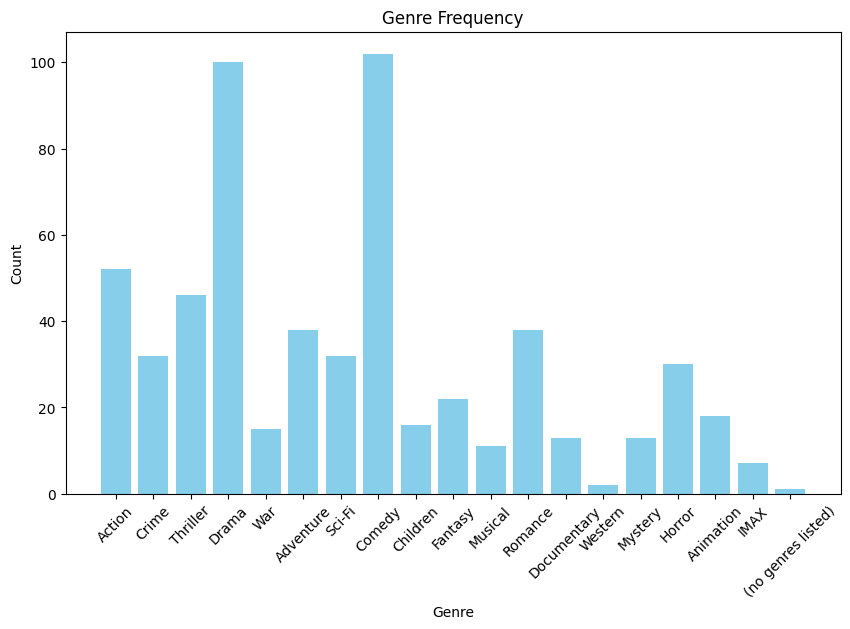

In [16]:
# storing cumulatively for each movies the user has seen its genres 
test_user_tastes = tastes(test_user_masked,movies)

# plotting the user tastes
# counting the occurencies of each genre 
genre_counts = Counter(test_user_tastes)

# separating the genre names and their counts
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.title('Genre Frequency')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


getting its recommendations using the final centroids from the NCF which have emerged has the best from the comparison

In [17]:
test_user_recc=recommendation(test_user_masked,final_centroids_ncf)
print(test_user_recc)

[314, 1938, 510, 3136, 615, 507, 897, 938, 0, 509]


visualizing them

In [18]:
movies[movies.index.isin(test_user_recc)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
314,315,Forrest Gump (1994),Comedy|Drama|Romance|War
507,508,Terminator 2: Judgment Day (1991),Action|Sci-Fi
509,510,Batman (1989),Action|Crime|Thriller
510,511,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
615,616,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
897,898,Cheech and Chong's Up in Smoke (1978),Comedy
938,939,Local Hero (1983),Comedy
1938,1939,"Walk on the Moon, A (1999)",Drama|Romance
3136,3137,"Longest Yard, The (1974)",Comedy


was he a hit or not? (will he watch at least one of the suggetsed movies?)

In [19]:
for i in test_user_recc:
    if test_user[i]==1:
        print('test user 12 is a hit')
        break

test user 12 is a hit


how many film will he watch?

In [20]:
print(test_user[test_user_recc])

[1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
